# Astronomical Object Detection (aka Battleships)

#### Detecting objects in noisy data is a fundamental aspect of astronomy.

#### So are simulations.

#### Contact details:

- Jonathan Zwart
- jtlz2@astro.columbia.edu
- 23 May 2017

#### Software requirements:

* python 2.x (e.g. anaconda or canopy)
* jupyter / ipython notebook
* numpy, scipy, matplotlib (pyplot)
* astropy (pip install astropy)

#### Let's roll.

## Flight checks

In [1]:
# Import modules

import os,sys
import warnings; warnings.simplefilter('ignore') # Take care here
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import norm
from astropy.modeling.models import Gaussian2D

# Magic syntax to place notebook plots inline
%matplotlib inline

__Q0. Set OUTDIR in the following cell__

In [2]:
# Change to suitable working directory [replace with your preferred location]
OUTDIR='/Users/jtlz2/uwc/teach/nassp-td2017'

## Simulation (aka generating mock data)

First let's generate a numpy array containing a uniformly-distributed random gaussian field but no (known) objects, and image it:

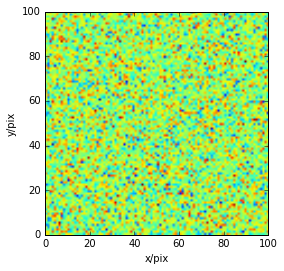

In [3]:
# The image is square, npix x npix
npix=100

# Integer noise seed - essential for reproducibility
np.random.seed(seed=1234)

# Noise RMS (per pixel)
std=1.0 # microJy (say)
field=np.random.normal(0.0,std,npix**2).reshape((npix,npix))

# Now image the field
data=field
plt.xlabel('x/pix')
plt.ylabel('y/pix')
plt.imshow(data,extent=(0.0,npix,0.0,npix))
plt.show()
plt.savefig(os.path.join(OUTDIR,'field-noiseonly.pdf'))

_Q1. Use matplotlib (plt) to plot a histogram of the pixel values in the next cell. How could you quantify the gaussianity of the field?_

In [4]:
# A1: Q1 answer here



Now let's use astropy to create some objects with circularly-symmetric gaussian morphologies, and place them in the noisy map.

In [5]:
# Set image dimensions
xmin=ymin=0.0
xmax=ymax=10.0 # degrees (say)
xx=yy=np.linspace(xmin,xmax,npix)

# Object properties stored in dictionaries
nobj=2
xs={0:40.0,1:65.0} # pix
ys={0:40.0,1:65.0} # pix
amps={0:100.0,1:100.0} # microJy
sigs={0:5.0,1:5.0} # pix

objs={}; g2d={}
for iobj in range(nobj):
    # specify properties
    g2d[iobj] = Gaussian2D(x_mean=xs[iobj], y_mean=ys[iobj],\
                           x_stddev=sigs[iobj], y_stddev=sigs[iobj])
    # specify the grid for the array
    objs[iobj]=g2d[iobj](*np.mgrid[0:npix,0:npix])



Let's replot the image, now with the nobj gaussian sources buried in the field:

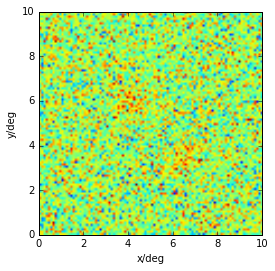

In [6]:
# Add the objects to the field...
data=field
for iobj in range(nobj):
    data+=objs[iobj]

# ...and plot
plt.xlabel('x/deg')
plt.ylabel('y/deg')
plt.imshow(data,extent=(xx.min(),xx.max(),yy.min(),yy.max()))
plt.show()
plt.savefig(os.path.join(OUTDIR,'field-withobjects.pdf'))

_Q2. Use matplotlib (plt) to plot a histogram of the pixel values in the next cell. Invent a figure-of-merit to detect the objects. What happens to your figure-of-merit if the data are too noisy, or less noisy? [hint: try plotting figure-of-merit vs. noise]_

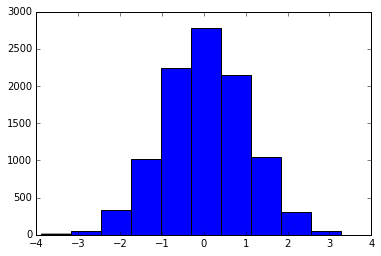

In [19]:
# A2: Q2 answer here
#plt.yscale('log')
plt.hist(data.flatten(),bins=10)
plt.show()


## Bayesian Object Detection

With the mock data $\mathrm{\mathbf{D}}$ now in hand, let's turn to Bayes' theorem,

$$
\mathcal{P}\left(\mathbf{\Theta}|\mathrm{\mathbf{D}},H\right)
= \frac{
\mathcal{L}\left(\mathrm{\mathbf{D}}|\mathbf{\Theta},H\right)
\mathit{\Pi}\left(\mathbf{\Theta}| H\right)}
{\mathcal{Z}\left(\mathrm{\mathbf{D}}| H\right)}.
$$

We will assume uniform priors $\mathit{\Pi}\left(\mathbf{\Theta}| H\right)$, so that the posterior $\mathcal{P}\left(\mathbf{\Theta}|\mathrm{\mathbf{D}},H\right)$ is just the likelihood $\mathcal{L}\left(\mathrm{\mathbf{D}}|\mathbf{\Theta},H\right)$ divided by a normalizing constant $\mathcal{Z}\left(\mathrm{\mathbf{D}}| H\right)$ (called the bayesian evidence).

Note that there are two gaussians at play here,

1. for the model $H$, the assumed morphology $\mathbf{\Theta}$ of the objects; and,
2. the form of the likelihood $\mathcal{L}$ (since the uncertainties are assumed to be gaussian),

with each of (1) and (2) having a corresponding mean and variance. For example, for the $i^{th}$ of $N$ data points

$$
\mathcal{L}_i\left(\mathrm{\mathbf{D}_i}|\mathbf{\Theta},H\right) =
\frac{1}{\sqrt{2\pi\sigma_i^2}}
\mathrm{e}^{
-\frac{
\left(
\mathbf{D}_i-\mathbf{D}_{i,\mathrm{model} } \left(\mathbf{\Theta}\right)
\right)^2
}{
2\sigma_i^2
}
}.
$$

The total log-likelihood $\ln\mathcal{L}$ can then be written

$$
-2\ln\mathcal{L}=N\ln\left(2\pi\sigma^2\right)+\sum_i^N\chi_i(\mathbf{\Theta})^2
$$

and the code for it is:

In [8]:
# (Log)-Likelihood function

def loglikelihood(xpos,ypos,sigpos,apos,sigma,data):
    loglike=0.0
    model=Gaussian2D(x_mean=xpos, y_mean=ypos, x_stddev=sigpos, y_stddev=sigpos)
    obj=apos*model(*np.mgrid[0:npix,0:npix])/(2.0*np.pi*sigpos**2)
    prefactor=0.5*npix*np.log(2.0*np.pi*sigma**2.0)
    chisq=0.5*np.power((data-obj/sigma),2.0).sum()
    loglike -= chisq + prefactor
    return loglike

_Q3._

1. _What are the parameters $\mathrm{\mathbf{D}}$ of the data?_
2. _What are the parameters $\mathbf{\Theta}$ of the model?_
3. _What have we assumed about the noise properties of the background field?_
4. _What have we assumed about the spatial variation of the background noise, and how does this affect the likelihood?_
5. _What have we assumed about the relationships between pixels?_


A3: Q3 answers here

1. .
2. .
3. .
4. .
5. .


Now we are going to evaluate the log-likelihood as a function of (xpos,ypos) over the field:

In [9]:
# Evaluate loglike across the field [SLOW!]

surface_xposypos=0.0*data
for ipos in range(npix):
    for jpos in range(npix):
        surface_xposypos[ipos,jpos]=loglikelihood(ipos,jpos,sigs[0],amps[0],std,data)

_Q4. What is Fortran-esque about the syntax above and what is pythonic? How would you make the code in that cell more pythonic? [hint: investigate list comprehensions] How would you accelerate the evaluation of the loglikelihood? What have we assumed about the morphology and flux of the objects we are looking for?_

A4: Q4 answer here



Now let's plot the likelihood surface:

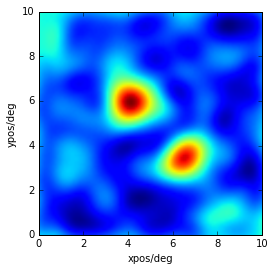

In [10]:
plt.xlabel('xpos/deg')
plt.ylabel('ypos/deg')
plt.imshow(surface_xposypos,extent=(xx.min(),xx.max(),yy.min(),yy.max()))
plt.show()
plt.savefig(os.path.join(OUTDIR,'loglike_x0y0.pdf'))

_Q5._

1. _What features can you see in the 2-D likelihood surface?_
2. _What problems arise if the objects are too close together on the sky?_
3. _Why have we kept the objects away from the edges of the field? What happens if they fall off the image? [hint: try it!]_
4. _Why is the notebook called 'battleships', and how does this exercise differ from the game?_

A5. Q5 answers here

1.

2.

3.

4.

_Q6. [hard - but why?] In this cell, write some code to extract the inferred estimates of the (xpos,ypos) positions of the sources. How could you summarize the inferred properties of the sources? [hint: what is $\mathbf{\hat{\Theta}}$ ?]_

In [11]:
# A5. Q5 answers here

Now we'll integrate the likelihood over the field:

In [12]:
logsum=surface_xposypos.sum()
print 'Proxy=%f' % logsum

Proxy=-51416903.758165


_Q6._

1. _What is the significance of this summation? What is the quantity a proxy for, and why? [hint: uniform priors]_
2. _How would you convert the value to a measure of probability?_
3. _Observationally, what could you use logsum for? [hint: what happens to it if you adjust std and/or amps?]_
4. _Calculate logsum when the _ __likelihood__ _ assumes no objects (keep the data the same)._
5. _Use (2), (3) and (4) to calculate a betting odds ratio (e.g.: 100.0:1) that there are nobj sources in the field ($H_{\mathrm{nobj}}$), vs. just noise in the field ($H_0$)._
6. _What is logsum for an empty field? Which model is preferred? [hint: change the data this time!]_
7. _What would happen if you got the assumed noise wrong? How could you mitigate this?_
8. _What would happen to the likelihood function if the telescope's electronics introduced a bias offset?_

A6. Q6 answers here

## Final thoughts

The 2-D marginalized likelihood calculated above is not the whole story; for example, we could evaluate the likelihood over the full (xpos,ypos,amppos,sigpos) surface.

But this is hard because the number of evaluations scales exponentially with the number of dimensions.

In practice, we can use Markov Chain Monte Carlo (MCMC) techniques to calculate the n-dimensional likelihood more efficiently.

It's worth writing a MCMC ('Metropolis-Hastings') sampler once in your life, but otherwise there are plenty of off-the-shelf libraries available. Be sure to know what you are doing if you use one of these, and never run them blindly!

Some examples of python MCMC implementations are:

1. emcee (http://dan.iel.fm/emcee/current)
2. PyMultinest (https://github.com/JohannesBuchner/PyMultiNest)

(2) additionally calculates the Bayesian evidence for us, which is harder to do (the 'curse of dimensionality').

See if you can evaluate the (amppos,sigpos) 2-D marginalized posterior distribution.

### Further reading:

1. http://www.inference.phy.cam.ac.uk/mackay/itila/book.html [complete, free survey of - inter alia - Bayes' theorem]

2. https://www.amazon.com/Data-Analysis-A-Bayesian-Tutorial/dp/0198568320 [ an easy introduction to doing Bayes]

3. https://www.amazon.co.uk/Theory-That-Would-Not-Die/dp/0300188226 [layman's history of Bayes' theorem]

4. https://arxiv.org/abs/astro-ph/0204457 [reviewed paper]

5. https://arxiv.org/abs/0811.1199 [advanced]

## ENDS